In [1]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

In [2]:
df = pd.read_csv('data.csv')
df.dropna(subset=['price'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


<Axes: >

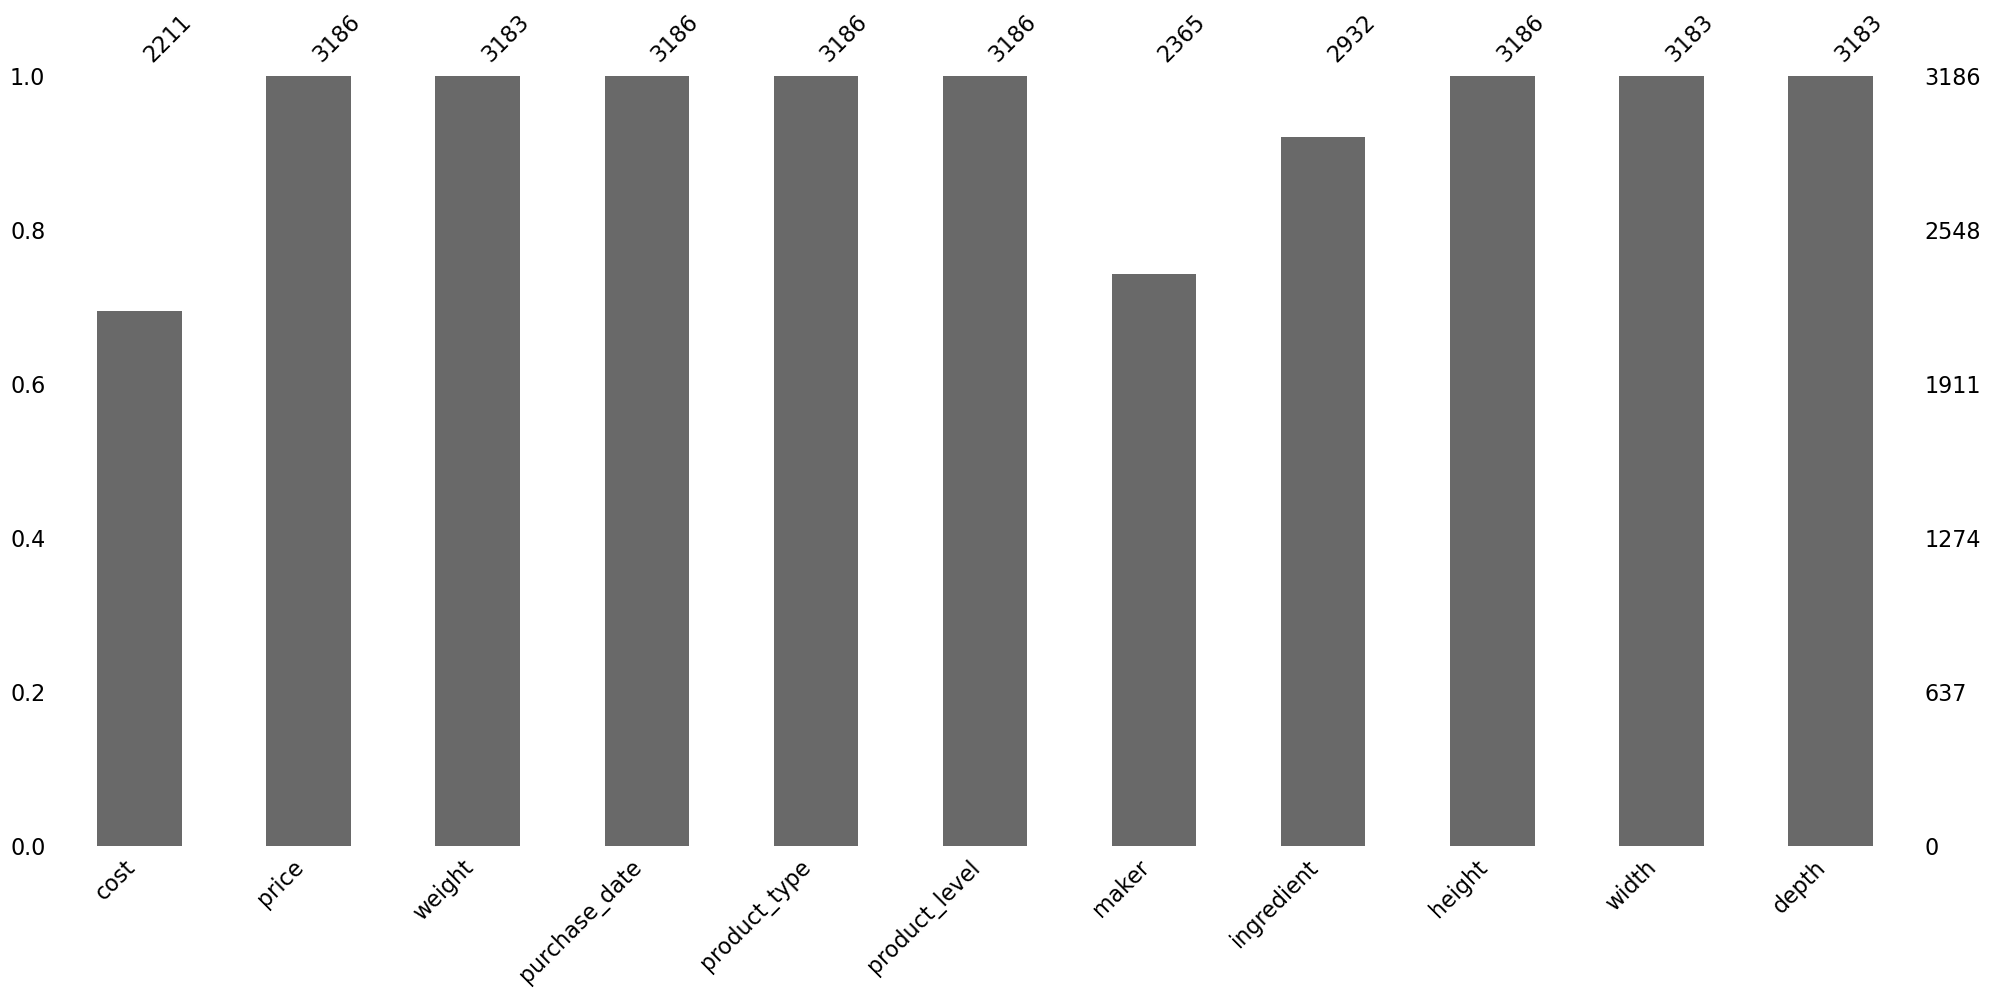

In [4]:
msno.bar(df)

In [5]:
features = list(df.columns)
target = 'price'
features.remove(target)

X = df[features]
y = df[target].str.strip("$").str.replace(",","").astype(float)

In [6]:
from sklearn.preprocessing import LabelEncoder
class Data_Transformer(object):
    
    def fit(self, X, y=None):
        self.pl_le = LabelEncoder() # create label-encoder
        self.pl_le.fit(X["product_level"]) # fit product level with label-encoder
        self.pt_le = LabelEncoder() # create label-encoder
        self.pt_le.fit_transform(X["product_type"]) # fit product type with label-encoder
        
    def transform(self, X, y=None):
        new_df = pd.DataFrame()
        new_df["Cost"] = X["cost"].str.strip("$").str.strip("k").astype(float)*1000 # convert cost to numerical value
        new_df["Weight"] = X["weight"].map(self.weight2num) # convert weight to numerical value
        new_df["Month"] = pd.to_datetime(X["purchase_date"]).dt.month # convert purchase date to purchase month
        new_df["Weekday"] = pd.to_datetime(X["purchase_date"]).dt.weekday # convert purchase date to purchase weekday
        new_df['Ingredient Number'] = X["ingredient"].map(self.get_numbers) # obtain number of ingredients in recipe
        new_df["Product Level"] = self.pl_le.transform(X["product_level"]) # transform product level with label-encoder
        new_df["Product Type"] = self.pt_le.transform(X["product_type"]) # transform product type with label-encoder
        return new_df # return new_df
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def weight2num(self, x): # function to convert weight to number
        if type(x) == str:
            x = x.strip('Kg').split(' Ton ')
            return float(x[0])*1000+float(x[1])
        else:
            return x
        
    def get_numbers(self, x): # function to get number of ingredients in recipe
        if type(x) == str:
            return len(x.split(','))
        else:
            return x

In [7]:
dtf = Data_Transformer()
X_transformed = dtf.fit_transform(X)

In [8]:
X_transformed

,Cost,Weight,Month,Weekday,Ingredient Number,Product Level,Product Type
0,333000.0,3090.0,12,4,2.0,0,40
1,NaN,3030.0,9,2,5.0,1,23
2,270000.0,3040.0,9,2,3.0,1,23
3,NaN,3050.0,12,4,3.0,0,55
4,97000.0,2970.0,1,2,3.0,0,9
...,...,...,...,...,...,...,...
3181,NaN,3000.0,11,4,5.0,0,6
3182,NaN,2830.0,5,4,6.0,2,22
3183,NaN,3080.0,12,4,9.0,2,5
3184,44000.0,2950.0,4,4,1.0,0,44


<Axes: >

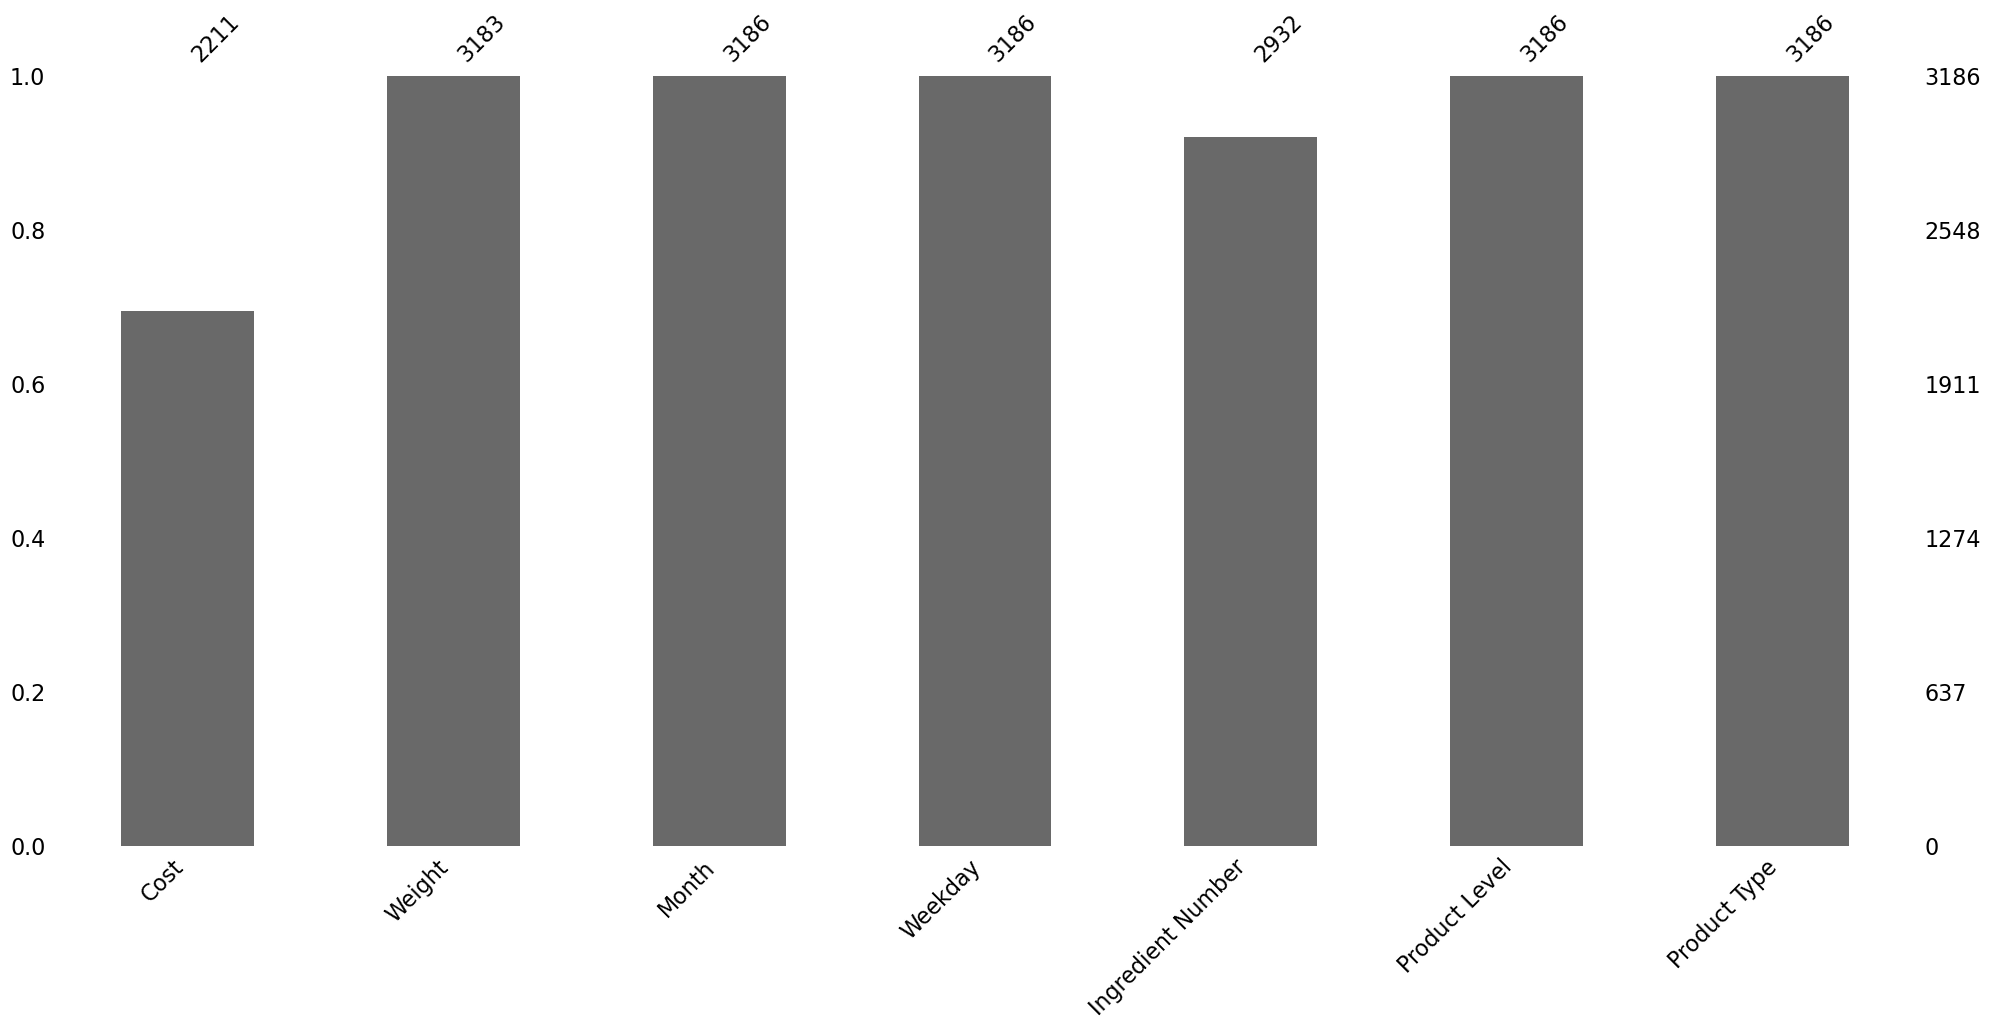

In [9]:
msno.bar(X_transformed)

In [10]:
imputer = SimpleImputer(strategy='mean')
X_mean_imputed = imputer.fit_transform(X_transformed)

In [11]:
X_mean_imputed

array([[3.33000000e+05, 3.09000000e+03, 1.20000000e+01, ...,
        2.00000000e+00, 0.00000000e+00, 4.00000000e+01],
       [1.69019448e+05, 3.03000000e+03, 9.00000000e+00, ...,
        5.00000000e+00, 1.00000000e+00, 2.30000000e+01],
       [2.70000000e+05, 3.04000000e+03, 9.00000000e+00, ...,
        3.00000000e+00, 1.00000000e+00, 2.30000000e+01],
       ...,
       [1.69019448e+05, 3.08000000e+03, 1.20000000e+01, ...,
        9.00000000e+00, 2.00000000e+00, 5.00000000e+00],
       [4.40000000e+04, 2.95000000e+03, 4.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 4.40000000e+01],
       [1.28000000e+05, 2.98000000e+03, 6.00000000e+00, ...,
        4.70941337e+00, 3.00000000e+00, 3.10000000e+01]])

In [12]:
X_mean_imputed = pd.DataFrame(X_mean_imputed, columns=["Cost","Weight","Month","Weekday","Ingredient Number","Product Level","Product Type"])
X_mean_imputed

,Cost,Weight,Month,Weekday,Ingredient Number,Product Level,Product Type
0,333000.000000,3090.0,12.0,4.0,2.000000,0.0,40.0
1,169019.448213,3030.0,9.0,2.0,5.000000,1.0,23.0
2,270000.000000,3040.0,9.0,2.0,3.000000,1.0,23.0
3,169019.448213,3050.0,12.0,4.0,3.000000,0.0,55.0
4,97000.000000,2970.0,1.0,2.0,3.000000,0.0,9.0
...,...,...,...,...,...,...,...
3181,169019.448213,3000.0,11.0,4.0,5.000000,0.0,6.0
3182,169019.448213,2830.0,5.0,4.0,6.000000,2.0,22.0
3183,169019.448213,3080.0,12.0,4.0,9.000000,2.0,5.0
3184,44000.000000,2950.0,4.0,4.0,1.000000,0.0,44.0


In [13]:
imputer = SimpleImputer(strategy='median')
X_median_imputed = imputer.fit_transform(X_transformed)

In [14]:
X_median_imputed

array([[3.33e+05, 3.09e+03, 1.20e+01, ..., 2.00e+00, 0.00e+00, 4.00e+01],
       [1.22e+05, 3.03e+03, 9.00e+00, ..., 5.00e+00, 1.00e+00, 2.30e+01],
       [2.70e+05, 3.04e+03, 9.00e+00, ..., 3.00e+00, 1.00e+00, 2.30e+01],
       ...,
       [1.22e+05, 3.08e+03, 1.20e+01, ..., 9.00e+00, 2.00e+00, 5.00e+00],
       [4.40e+04, 2.95e+03, 4.00e+00, ..., 1.00e+00, 0.00e+00, 4.40e+01],
       [1.28e+05, 2.98e+03, 6.00e+00, ..., 4.00e+00, 3.00e+00, 3.10e+01]])

In [15]:
X_median_imputed = pd.DataFrame(X_median_imputed, columns=["Cost","Weight","Month","Weekday","Ingredient Number","Product Level","Product Type"])
X_median_imputed

,Cost,Weight,Month,Weekday,Ingredient Number,Product Level,Product Type
0,333000.0,3090.0,12.0,4.0,2.0,0.0,40.0
1,122000.0,3030.0,9.0,2.0,5.0,1.0,23.0
2,270000.0,3040.0,9.0,2.0,3.0,1.0,23.0
3,122000.0,3050.0,12.0,4.0,3.0,0.0,55.0
4,97000.0,2970.0,1.0,2.0,3.0,0.0,9.0
...,...,...,...,...,...,...,...
3181,122000.0,3000.0,11.0,4.0,5.0,0.0,6.0
3182,122000.0,2830.0,5.0,4.0,6.0,2.0,22.0
3183,122000.0,3080.0,12.0,4.0,9.0,2.0,5.0
3184,44000.0,2950.0,4.0,4.0,1.0,0.0,44.0


In [16]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
X_knn_imputed = imputer.fit_transform(X_transformed)

In [17]:
X_knn_imputed

array([[3.330e+05, 3.090e+03, 1.200e+01, ..., 2.000e+00, 0.000e+00,
        4.000e+01],
       [2.478e+05, 3.030e+03, 9.000e+00, ..., 5.000e+00, 1.000e+00,
        2.300e+01],
       [2.700e+05, 3.040e+03, 9.000e+00, ..., 3.000e+00, 1.000e+00,
        2.300e+01],
       ...,
       [2.888e+05, 3.080e+03, 1.200e+01, ..., 9.000e+00, 2.000e+00,
        5.000e+00],
       [4.400e+04, 2.950e+03, 4.000e+00, ..., 1.000e+00, 0.000e+00,
        4.400e+01],
       [1.280e+05, 2.980e+03, 6.000e+00, ..., 2.000e+00, 3.000e+00,
        3.100e+01]])

In [18]:
X_knn_imputed = pd.DataFrame(X_knn_imputed, columns=["Cost","Weight","Month","Weekday","Ingredient Number","Product Level","Product Type"])
X_knn_imputed

,Cost,Weight,Month,Weekday,Ingredient Number,Product Level,Product Type
0,333000.0,3090.0,12.0,4.0,2.0,0.0,40.0
1,247800.0,3030.0,9.0,2.0,5.0,1.0,23.0
2,270000.0,3040.0,9.0,2.0,3.0,1.0,23.0
3,93400.0,3050.0,12.0,4.0,3.0,0.0,55.0
4,97000.0,2970.0,1.0,2.0,3.0,0.0,9.0
...,...,...,...,...,...,...,...
3181,98200.0,3000.0,11.0,4.0,5.0,0.0,6.0
3182,202800.0,2830.0,5.0,4.0,6.0,2.0,22.0
3183,288800.0,3080.0,12.0,4.0,9.0,2.0,5.0
3184,44000.0,2950.0,4.0,4.0,1.0,0.0,44.0


<Axes: >

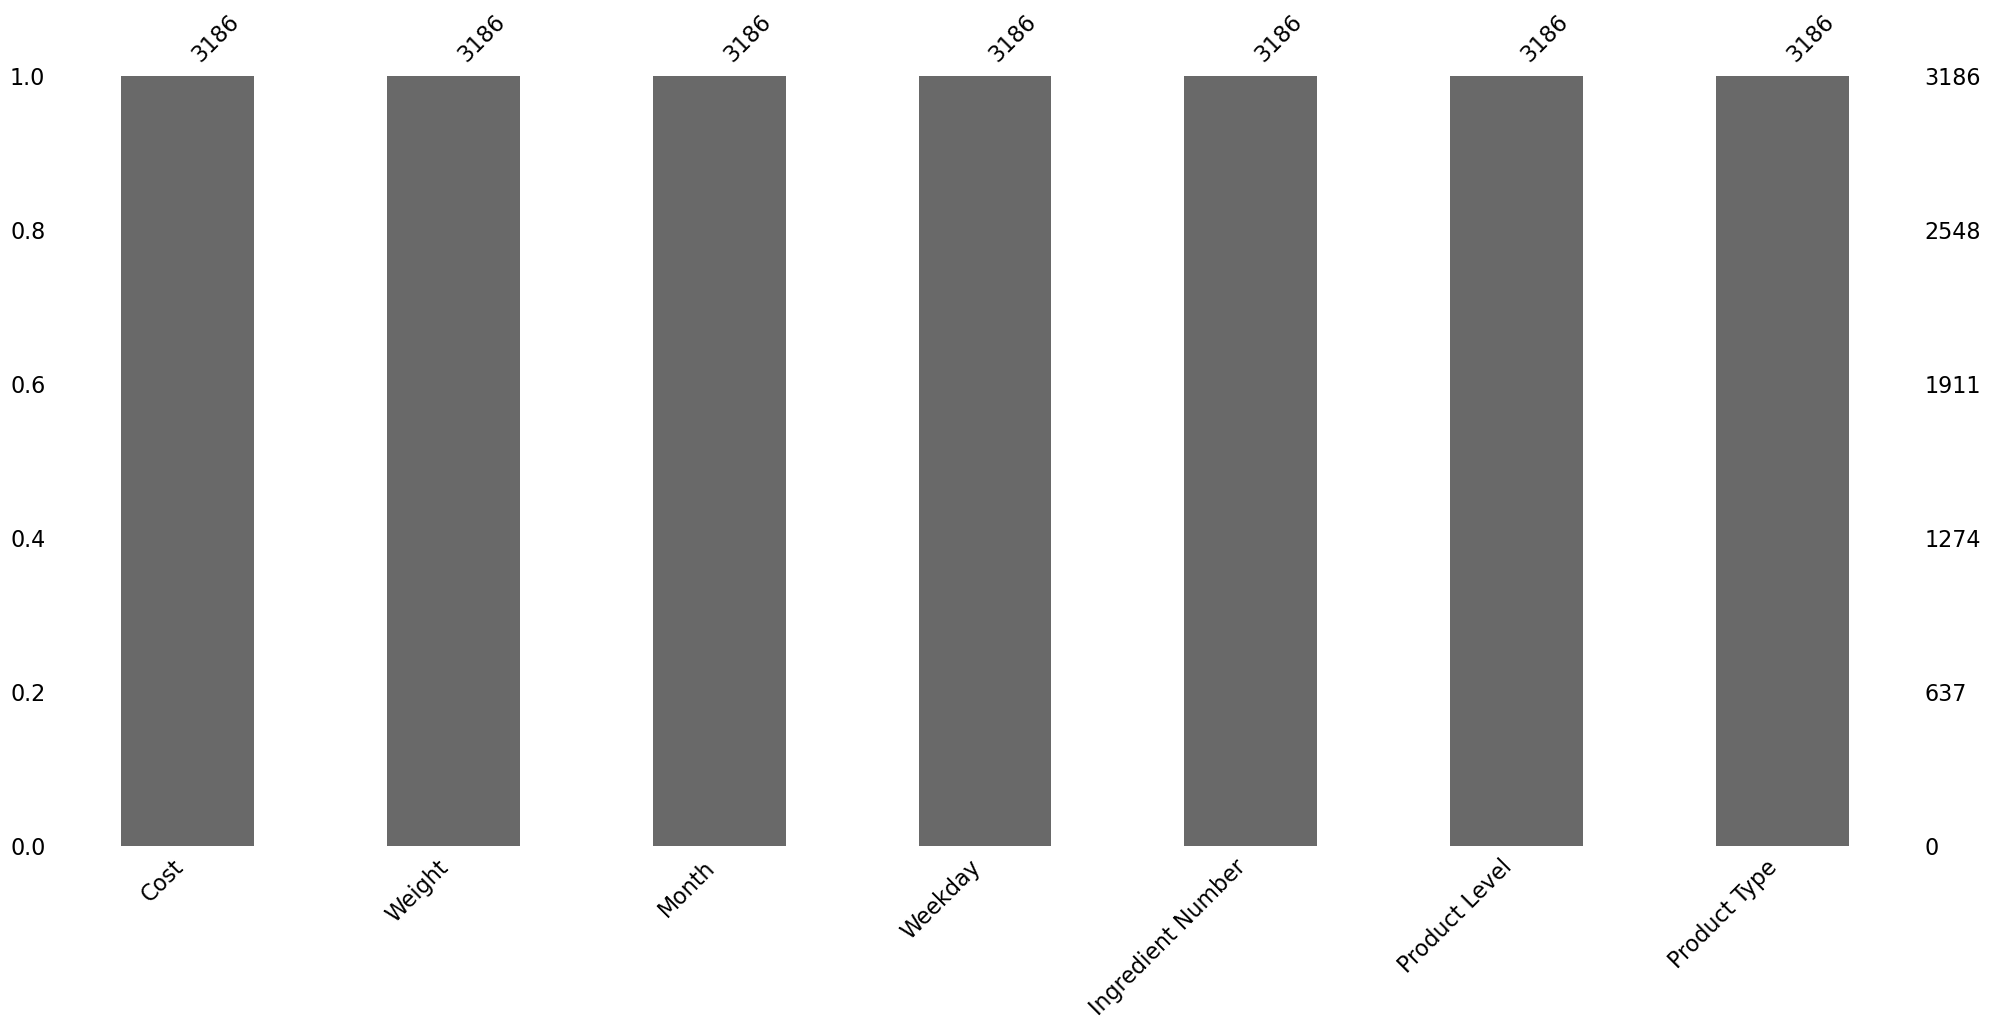

In [19]:
msno.bar(X_knn_imputed)

In [20]:
imputer = IterativeImputer()
X_mice_imputed = imputer.fit_transform(X_transformed)

In [21]:
X_mice_imputed

array([[3.33000000e+05, 3.09000000e+03, 1.20000000e+01, ...,
        2.00000000e+00, 0.00000000e+00, 4.00000000e+01],
       [1.72641555e+05, 3.03000000e+03, 9.00000000e+00, ...,
        5.00000000e+00, 1.00000000e+00, 2.30000000e+01],
       [2.70000000e+05, 3.04000000e+03, 9.00000000e+00, ...,
        3.00000000e+00, 1.00000000e+00, 2.30000000e+01],
       ...,
       [1.90741076e+05, 3.08000000e+03, 1.20000000e+01, ...,
        9.00000000e+00, 2.00000000e+00, 5.00000000e+00],
       [4.40000000e+04, 2.95000000e+03, 4.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 4.40000000e+01],
       [1.28000000e+05, 2.98000000e+03, 6.00000000e+00, ...,
        3.95899081e+00, 3.00000000e+00, 3.10000000e+01]])

In [22]:
X_mice_imputed = pd.DataFrame(X_mice_imputed, columns=["Cost","Weight","Month","Weekday","Ingredient Number","Product Level","Product Type"])
X_mice_imputed

,Cost,Weight,Month,Weekday,Ingredient Number,Product Level,Product Type
0,333000.000000,3090.0,12.0,4.0,2.000000,0.0,40.0
1,172641.555388,3030.0,9.0,2.0,5.000000,1.0,23.0
2,270000.000000,3040.0,9.0,2.0,3.000000,1.0,23.0
3,127611.807770,3050.0,12.0,4.0,3.000000,0.0,55.0
4,97000.000000,2970.0,1.0,2.0,3.000000,0.0,9.0
...,...,...,...,...,...,...,...
3181,165542.495048,3000.0,11.0,4.0,5.000000,0.0,6.0
3182,119895.898120,2830.0,5.0,4.0,6.000000,2.0,22.0
3183,190741.075789,3080.0,12.0,4.0,9.000000,2.0,5.0
3184,44000.000000,2950.0,4.0,4.0,1.000000,0.0,44.0


In [23]:
pristine_cost = 1000*X["cost"].str.strip("$").str.strip("k").astype(float)

(0.0, 600000.0)

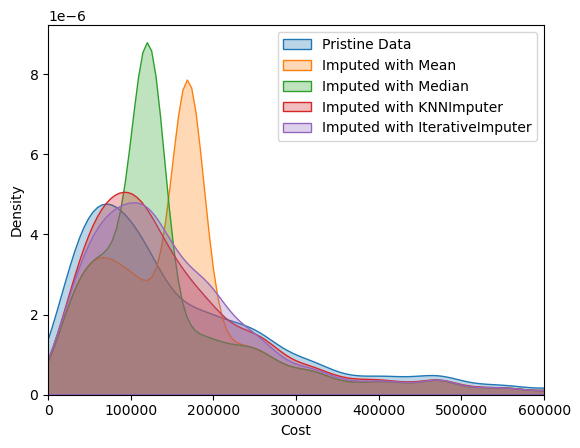

In [24]:
sns.kdeplot(pristine_cost, bw_adjust=0.8, label='Pristine Data', fill=True, alpha=0.3)
sns.kdeplot(data=X_mean_imputed, x="Cost", bw_adjust=0.8, label='Imputed with Mean', fill=True, alpha=0.3)
sns.kdeplot(data=X_median_imputed, x="Cost", bw_adjust=0.8, label='Imputed with Median', fill=True, alpha=0.3)
sns.kdeplot(data=X_knn_imputed, x="Cost", bw_adjust=0.8, label='Imputed with KNNImputer', fill=True, alpha=0.3)
sns.kdeplot(data=X_mice_imputed, x="Cost", bw_adjust=0.8, label='Imputed with IterativeImputer', fill=True, alpha=0.3)
plt.xlabel('Cost')
plt.legend()
plt.xlim(0,600000)